# Patel_Nirav_Term_Project:  
## Student ID: nxp164730
## Date: 12/06/2018
 

###                                Google Store Revenue Prediction

In [2]:
# Necessary librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.stats import kurtosis, skew 
import json 
from pandas.io.json import json_normalize 
from sklearn.model_selection import train_test_split
import ast
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
import operator
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
import os 
import random 

### Importing Data

In [50]:
masterdata = pd.read_csv('data.csv')

In [51]:
pd.set_option('display.max_columns', 500)
masterdata.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,trafficSource,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,totals_visits
0,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,{'mobileDeviceInfo': 'not available in demo da...,3162355547410993243,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508198450,1,1508198450,1.0,1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1
1,Referral,"[{'index': '4', 'value': 'North America'}]",20171016,{'mobileDeviceInfo': 'not available in demo da...,8934116514970143966,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,{'referralPath': '/a/google.com/transportation...,1508176307,6,1508176307,NaN,2,NaN,2.0,2.0,28.0,NaN,NaN,NaN,1
2,Direct,"[{'index': '4', 'value': 'North America'}]",20171016,{'mobileDeviceInfo': 'not available in demo da...,7992466427990357681,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '17',...",Not Socially Engaged,"{'isTrueDirect': True, 'campaign': '(not set)'...",1508201613,1,1508201613,NaN,2,1.0,2.0,1.0,38.0,NaN,NaN,NaN,1
3,Organic Search,"[{'index': '4', 'value': 'EMEA'}]",20171016,{'mobileDeviceInfo': 'not available in demo da...,9075655783635761930,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '9', ...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508169851,1,1508169851,NaN,2,1.0,2.0,1.0,1.0,NaN,NaN,NaN,1
4,Organic Search,"[{'index': '4', 'value': 'Central America'}]",20171016,{'mobileDeviceInfo': 'not available in demo da...,6960673291025684308,"{'cityId': 'not available in demo dataset', 'm...","[{'hitNumber': '1', 'time': '0', 'hour': '14',...",Not Socially Engaged,"{'campaign': '(not set)', 'source': 'google', ...",1508190552,1,1508190552,NaN,2,1.0,2.0,1.0,52.0,NaN,NaN,NaN,1


### Breaking Nested Columns to individual columns-1
By looking at the data, it seems that there are several layers of deeply nested data(columns). Hence the first step would be to get the data from nested format.

In [52]:
# for customDimensions and hits columns
def parse_special_col(raw_str):
    lst = ast.literal_eval(raw_str)
    if isinstance(lst, list) and lst:
        return pd.Series(lst[0])
    else:
        return pd.Series({})

In [53]:
# for customDimensions
customDimensions_df = masterdata.customDimensions.apply(parse_special_col)
customDimensions_df.columns = [f'customDimensions_{x}' for x in customDimensions_df.columns]
masterdata = pd.concat([masterdata, customDimensions_df], axis=1)
masterdata.drop('customDimensions', axis=1, inplace=True)

In [54]:
# for hits
hits_df = masterdata.hits.apply(parse_special_col)
hits_df.columns = [f'hits_{x}' for x in hits_df.columns]
masterdata = pd.concat([masterdata, hits_df], axis=1)
masterdata.drop('hits', axis=1, inplace=True) 

### Droping empty hits columns
This step is to clean the data by dropping the empty hits column.

In [55]:
#hits_experiment, hits_customVariables, hits_customMetrics, hits_publisher_infos, hits_customDimensions are empty:
masterdata.drop(['hits_experiment', 'hits_customVariables', 'hits_customMetrics', 'hits_publisher_infos', 'hits_customDimensions'], axis=1, inplace=True)

### Breaking Nested Columns to individual columns-2
At this step, we are converting the data into individual columns(flattening the data).

In [8]:
#hits_product, hits_promotion are python list
def parse_list(x):
    if isinstance(x, list) and x:
        return pd.Series(x[0])
    else:
        return pd.Series({})
    
for col in ['hits_product', 'hits_promotion']:
    parsed_df = hits_df[col].apply(parse_list)
    parsed_df.columns = [f'{col}_{x}' for x in parsed_df.columns]
    masterdata = pd.concat([masterdata, parsed_df], axis=1)
    masterdata.drop(col, axis=1, inplace=True)

In [9]:
dict_cols = ['hits_page', 'hits_transaction', 'hits_item', 'hits_appInfo', 
        'hits_exceptionInfo', 'hits_eCommerceAction', 'hits_social', 'hits_contentGroup', 'hits_promotionActionInfo']
for col in dict_cols:
    parsed_df = hits_df[col].apply(pd.Series)
    parsed_df.columns = [f'{col}_{x}' for x in parsed_df.columns]
    masterdata = pd.concat([masterdata, parsed_df], axis=1)
    masterdata.drop(col, axis=1, inplace=True)

C:\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:57: RuntimeWarning:

'<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects

C:\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:87: RuntimeWarning:

'<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects

C:\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:57: RuntimeWarning:

'<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects

C:\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:87: RuntimeWarning:

'<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects



In [10]:
# For Devices

d = masterdata[['device']]

import ast
for i in range(len(d.device)): 
    d.device[i] = ast.literal_eval(d.device[i])
    
    
def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        tmp = pd.DataFrame((d for idx, d in df[column].iteritems()))
        ret = pd.concat([df.drop(column,axis=1), tmp], axis=1)
    else:
        tmp = pd.DataFrame((d for idx, d in 
        df[column].iteritems())).fillna(fillna)
        ret = pd.concat([df.drop(column,axis=1), tmp], axis=1)
    return ret

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [12]:
device_flat = unpack(d, 'device')

In [13]:
#for Geo
g = masterdata[['geoNetwork']]
for i in range(len(g.geoNetwork)): 
    g.geoNetwork[i] = ast.literal_eval(g.geoNetwork[i])
    
def unpack(df, column, fillna=None):
    ret = None
    if fillna is None:
        tmp = pd.DataFrame((g for idx, g in df[column].iteritems()))
        ret = pd.concat([df.drop(column,axis=1), tmp], axis=1)
    else:
        tmp = pd.DataFrame((g for idx, d in 
        df[column].iteritems())).fillna(fillna)
        ret = pd.concat([df.drop(column,axis=1), tmp], axis=1)
    return ret

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [14]:
geo_flat = unpack(g, 'geoNetwork')

In [15]:
#for Traffic Source
t = masterdata[['trafficSource']]
for i in range(len(t.trafficSource)): 
    t.trafficSource[i] = ast.literal_eval(t.trafficSource[i])
    
def unpackt(df, column, fillna=None):
    ret = None
    if fillna is None:
        tmp = pd.DataFrame((t for idx, t in df[column].iteritems()))
        ret = pd.concat([df.drop(column,axis=1), tmp], axis=1)
    else:
        tmp = pd.DataFrame((t for idx, d in 
        df[column].iteritems())).fillna(fillna)
        ret = pd.concat([df.drop(column,axis=1), tmp], axis=1)
    return ret

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [16]:
traffic_flat = unpack(t, 'trafficSource')

In [18]:
# dropping original columns of geo, device, traffic
masterdata=masterdata.drop(['device', 'geoNetwork', 'trafficSource','totals_totalTransactionRevenue'], axis=1)
litedata = pd.concat([masterdata, geo_flat, device_flat,traffic_flat], axis=1)

## Overview of the flattened data

In [20]:
pd.set_option('display.max_columns', 500)
litedata.head()

,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,totals_visits,customDimensions_index,customDimensions_value,hits_dataSource,hits_eventInfo,hits_hitNumber,hits_hour,hits_isEntrance,hits_isExit,hits_isInteraction,hits_minute,hits_referer,hits_time,hits_type,hits_product_customDimensions,hits_product_customMetrics,hits_product_isClick,hits_product_isImpression,hits_product_localProductPrice,hits_product_productBrand,hits_product_productListName,hits_product_productListPosition,hits_product_productPrice,hits_product_productQuantity,hits_product_productSKU,hits_product_productVariant,hits_product_v2ProductCategory,hits_product_v2ProductName,hits_promotion_promoCreative,hits_promotion_promoId,hits_promotion_promoName,hits_promotion_promoPosition,hits_page_hostname,hits_page_pagePath,hits_page_pagePathLevel1,hits_page_pagePathLevel2,hits_page_pagePathLevel3,hits_page_pagePathLevel4,hits_page_pageTitle,hits_page_searchCategory,hits_page_searchKeyword,hits_page_0,hits_transaction_currencyCode,hits_transaction_0,hits_item_currencyCode,hits_item_0,hits_appInfo_exitScreenName,hits_appInfo_landingScreenName,hits_appInfo_screenDepth,hits_appInfo_screenName,hits_appInfo_0,hits_exceptionInfo_isFatal,hits_exceptionInfo_0,hits_eCommerceAction_action_type,hits_eCommerceAction_step,hits_eCommerceAction_0,hits_social_hasSocialSourceReferral,hits_social_socialInteractionNetworkAction,hits_social_socialNetwork,hits_social_0,hits_contentGroup_contentGroup1,hits_contentGroup_contentGroup2,hits_contentGroup_contentGroup3,hits_contentGroup_contentGroup4,hits_contentGroup_contentGroup5,hits_contentGroup_contentGroupUniqueViews1,hits_contentGroup_contentGroupUniqueViews2,hits_contentGroup_contentGroupUniqueViews3,hits_contentGroup_previousContentGroup1,hits_contentGroup_previousContentGroup2,hits_contentGroup_previousContentGroup3,hits_contentGroup_previousContentGroup4,hits_contentGroup_previousContentGroup5,hits_contentGroup_0,hits_promotionActionInfo_0,hits_promotionActionInfo_promoIsView,hits_promotionActionInfo_promoIsClick,city,cityId,continent,country,latitude,longitude,metro,networkDomain,networkLocation,region,subContinent,browser,browserSize,browserVersion,deviceCategory,flashVersion,isMobile,language,mobileDeviceBranding,mobileDeviceInfo,mobileDeviceMarketingName,mobileDeviceModel,mobileInputSelector,operatingSystem,operatingSystemVersion,screenColors,screenResolution,adContent,adwordsClickInfo,campaign,isTrueDirect,keyword,medium,referralPath,source
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,1.0,1,1.0,1.0,1.0,NaN,NaN,NaN,1,4,EMEA,web,NaN,1,17,True,True,True,0,https://www.google.co.uk/search?q=water+bottle...,0,PAGE,[],[],NaN,True,23990000,(not set),Category,1,23990000,NaN,GGOEGDHC074099,(not set),Home/Drinkware/Water Bottles and Tumblers/,Google 17oz Stainless Steel Sport Bottle,NaN,NaN,NaN,NaN,shop.googlemerchandisestore.com,/google+redesign/bags/water+bottles+and+tumblers,/google+redesign/,/bags/,/water+bottles+and+tumblers,,Water Bottles & Tumblers | Drinkware | Google ...,NaN,NaN,NaN,USD,NaN,USD,NaN,shop.googlemerchandisestore.com/google+redesig...,shop.googlemerchandisestore.com/google+redesig...,0,shop.googlemerchandisestore.com/google+redesig...,NaN,True,NaN,0,1,NaN,No,:,(not set),NaN,(not set),Bags,(not set),(not set),(not set),NaN,1,NaN,(entrance),(entrance),(entrance),(entrance),(entrance),NaN,NaN,NaN,NaN,not available in demo dataset,not available in demo dataset,Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,Western Europe,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not av

## Checking Missing Value Percentage in all the columns
In order to clean the data, we need to find and ride of missing value sections.

In [21]:
miss_per = {}
for k, v in dict(litedata.isna().sum(axis=0)).items():
    if v == 0:
        continue
    miss_per[k] = 100 * float(v) / len(litedata)

sorted_x = sorted(miss_per.items(), key=operator.itemgetter(1), reverse=True)
print ("There are " + str(len(miss_per)) + " columns with missing values")

kys = [_[0] for _ in sorted_x][::-1]
vls = [_[1] for _ in sorted_x][::-1]
trace1 = go.Bar(y = kys, orientation="h" , x = vls, marker=dict(color="#d6a5ff"))
layout = go.Layout(title="Missing Values Percentage", 
                   xaxis=dict(title="Missing Percentage"), 
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

There are 87 columns with missing values


So we can observe that there are many columns in the dataset having very large number of missing values.

### We will now delete any column which has all Null or Unique values
As from above,we can see that there is higher percentage of data which is missing. Here we are removing those null or unique values.

In [24]:
#Find any unique value and drop them
litedata = litedata.drop(labels=litedata.columns[litedata.nunique()==1],axis=1)

## Exploration of the Cleaned Data

Analysis of Device Attributes 

In [31]:
device_cols = ["browser", "deviceCategory", "operatingSystem"]
colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
traces = []
for i, col in enumerate(device_cols):
    t = litedata[col].value_counts()
    traces.append(go.Bar(marker=dict(color=colors[i]),orientation="h", y = t.index[:15][::-1], x = t.values[:15][::-1]))
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits: Category", "Visits: Browser","Visits: OS"], print_grid=False)
fig.append_trace(traces[1], 1, 1)
fig.append_trace(traces[0], 1, 2)
fig.append_trace(traces[2], 1, 3)
fig['layout'].update(height=400, showlegend=False, title="Visits by Device Attributes")
iplot(fig)

In [32]:
litedata["totals_transactionRevenue"] = litedata["totals_transactionRevenue"].astype('float')
device_cols = ["browser", "deviceCategory", "operatingSystem"]
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Mean Revenue: Category", "Mean Revenue: Browser","Mean Revenue: OS"], print_grid=False)
colors = ["red", "green", "purple"]
trs = []
for i, col in enumerate(device_cols):
    tmp = litedata.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(x = tmp["Mean Revenue"][::-1], orientation="h", marker=dict(opacity=0.5, color=colors[i]), y = tmp[col][::-1])
    trs.append(tr)
fig.append_trace(trs[1], 1, 1)
fig.append_trace(trs[0], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False, title="Mean Revenue by Device Attributes")
iplot(fig)

Analysis of Geo segmentation attributes

In [29]:
geo_cols = ['city', 'continent','country',
            'metro', 'networkDomain', 'region','subContinent']
geo_cols = ['continent','subContinent']
colors = ["#d6a5ff", "#fca6da"]
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Visits : GeoNetwork Continent", "Visits : GeoNetwork subContinent"], print_grid=False)
trs = []
for i,col in enumerate(geo_cols):
    t = litedata[col].value_counts()
    tr = go.Bar(x = t.index[:20], marker=dict(color=colors[i]), y = t.values[:20])
    trs.append(tr)
fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=400, margin=dict(b=150), showlegend=False)
iplot(fig)

In [30]:
geo_cols = ['continent','subContinent']
fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["Mean Revenue: Continent", "Mean Revenue: SubContinent"], print_grid=False)
colors = ["blue", "orange"]
trs = []
for i, col in enumerate(geo_cols):
    tmp = litedata.groupby(col).agg({"totals_transactionRevenue": "mean"}).reset_index().rename(columns={"totals_transactionRevenue" : "Mean Revenue"})
    tmp = tmp.dropna().sort_values("Mean Revenue", ascending = False)
    tr = go.Bar(y = tmp["Mean Revenue"], orientation="v", marker=dict(opacity=0.5, color=colors[i]), x= tmp[col])
    trs.append(tr)
fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig['layout'].update(height=450, margin=dict(b=200), showlegend=False)
iplot(fig)

In [34]:
# Traffic Attributes

fig = tools.make_subplots(rows=1, cols=2, subplot_titles=["TrafficSource Campaign", "TrafficSource Medium"], print_grid=False)

colors = ["#d6a5ff", "#fca6da", "#f4d39c", "#a9fcca"]
t1 = litedata["campaign"].value_counts()
t2 = litedata["medium"].value_counts()
tr1 = go.Bar(x = t1.index, y = t1.values, marker=dict(color=colors[3]))
tr2 = go.Bar(x = t2.index, y = t2.values, marker=dict(color=colors[2]))
tr3 = go.Bar(x = t1.index[1:], y = t1.values[1:], marker=dict(color=colors[0]))
tr4 = go.Bar(x = t2.index[1:], y = t2.values[1:])

fig.append_trace(tr3, 1, 1)
fig.append_trace(tr2, 1, 2)
fig['layout'].update(height=400, margin=dict(b=100), showlegend=False)
iplot(fig)

In [117]:
# Channel Grouping
tmp = litedata["channelGrouping"].value_counts()
colors = ["#8d44fc", "#ed95d5", "#caadf7", "#6161b7", "#7e7eba", "#babad1"]
trace = go.Pie(labels=tmp.index, values=tmp.values, marker=dict(colors=colors))
layout = go.Layout(title="Channel Grouping", height=400)
fig = go.Figure(data = [trace], layout = layout)
iplot(fig, filename='basic_pie_chart')

In [35]:
# Monthly visit trends

def _add_date_features(df):
    df['date'] = df['date'].astype(str)
    df["date"] = df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
    df["date"] = pd.to_datetime(df["date"])
    
    df["month"]   = df['date'].dt.month
    df["day"]     = df['date'].dt.day
    df["weekday"] = df['date'].dt.weekday
    return df 

masterdata = _add_date_features(masterdata)

tmp = masterdata['date'].value_counts().to_frame().reset_index().sort_values('index')
tmp = tmp.rename(columns = {"index" : "dateX", "date" : "visits"})

tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["visits"])
layout = go.Layout(title="Visits by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [36]:
tmp = masterdata.groupby("date").agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp = tmp.rename(columns = {"date" : "dateX", "totals_transactionRevenue" : "mean_revenue"})
tr = go.Scatter(mode="lines", x = tmp["dateX"].astype(str), y = tmp["mean_revenue"])
layout = go.Layout(title="MonthlyRevenue by date", height=400)
fig = go.Figure(data = [tr], layout = layout)
iplot(fig)

In [37]:
vn = masterdata["visitNumber"].value_counts()
def vn_bins(x):
    if x == 1:
        return "1" 
    elif x < 5:
        return "2-5"
    elif x < 10:
        return "5-10"
    elif x < 50:
        return "10-50"
    elif x < 100:
        return "50-100"
    else:
        return "100+"
    
vn = masterdata["visitNumber"].apply(vn_bins).value_counts()

trace1 = go.Bar(y = vn.index[::-1], orientation="h" , x = vn.values[::-1], marker=dict(color="#7af9ad"))
layout = go.Layout(title="Visit Numbers Distribution", 
                   xaxis=dict(title="Frequency"),yaxis=dict(title="VisitNumber") ,
                   height=400, margin=dict(l=300, r=300))
figure = go.Figure(data = [trace1], layout = layout)
iplot(figure)

In [38]:
fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["Visits by Month", "Visits by MonthDay", "Visits by WeekDay"], print_grid=False)
trs = []
for i,col in enumerate(["month", "day", "weekday"]):
    t = masterdata[col].value_counts()
    tr = go.Bar(x = t.index, marker=dict(color=colors[i]), y = t.values)
    trs.append(tr)

fig.append_trace(trs[0], 1, 1)
fig.append_trace(trs[1], 1, 2)
fig.append_trace(trs[2], 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

In [39]:
tmp1 = masterdata.groupby('month').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp2 = masterdata.groupby('day').agg({"totals_transactionRevenue" : "mean"}).reset_index()
tmp3 = masterdata.groupby('weekday').agg({"totals_transactionRevenue" : "mean"}).reset_index()

fig = tools.make_subplots(rows=1, cols=3, subplot_titles=["MeanRevenue by Month", "MeanRevenue by MonthDay", "MeanRevenue by WeekDay"], print_grid=False)
tr1 = go.Bar(x = tmp1.month, marker=dict(color="red", opacity=0.5), y = tmp1.totals_transactionRevenue)
tr2 = go.Bar(x = tmp2.day, marker=dict(color="orange", opacity=0.5), y = tmp2.totals_transactionRevenue)
tr3 = go.Bar(x = tmp3.weekday, marker=dict(color="green", opacity=0.5), y = tmp3.totals_transactionRevenue)

fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 2)
fig.append_trace(tr3, 1, 3)
fig['layout'].update(height=400, showlegend=False)
iplot(fig)

Combining transaction at User level

In [42]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

agg_dict = {}
for col in ["totals_bounces", "totals_hits", "totals_newVisits", "totals_pageviews", "totals_transactionRevenue"]:
    litedata[col] = litedata[col].astype('float')
    agg_dict[col] = "sum"
tmp = litedata.groupby("fullVisitorId").agg(agg_dict).reset_index()
tmp.head()

,fullVisitorId,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_transactionRevenue
0,88640475884751,0.0,24.0,1.0,23.0,0.0
1,189307122537490,1.0,1.0,1.0,1.0,0.0
2,245437374675368,0.0,2.0,1.0,2.0,0.0
3,310185102568481,0.0,2.0,0.0,2.0,0.0
4,558077087682879,1.0,1.0,1.0,1.0,0.0


There are 189 visitors in the train dataset having non zero total transaction revenue


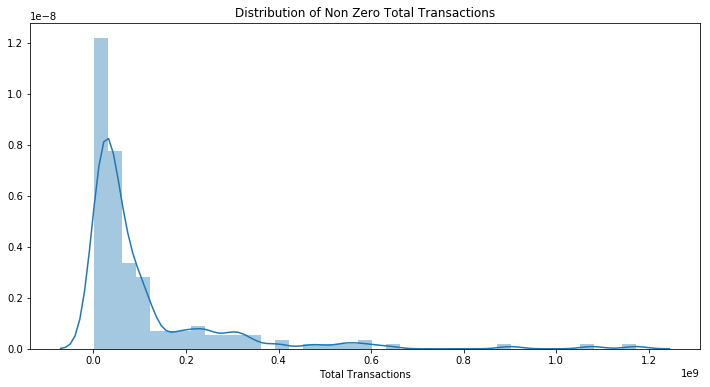

In [43]:
non_zero = tmp[tmp["totals_transactionRevenue"] > 0]["totals_transactionRevenue"]
print ("There are " + str(len(non_zero)) + " visitors in the train dataset having non zero total transaction revenue")

plt.figure(figsize=(12,6))
sns.distplot(non_zero)
plt.title("Distribution of Non Zero Total Transactions")
plt.xlabel("Total Transactions")

Text(0.5,0,'Log - Total Transactions')

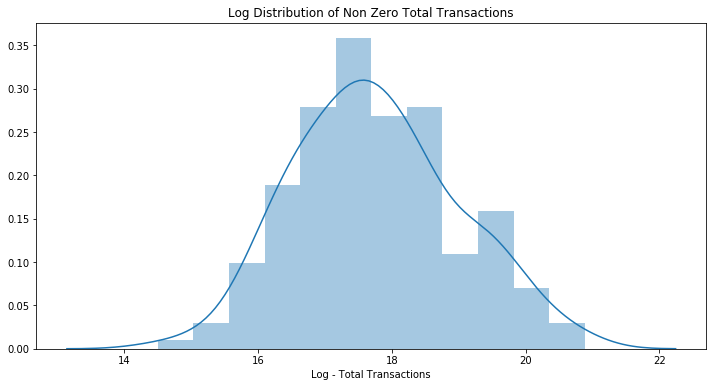

In [44]:
plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Log Distribution of Non Zero Total Transactions")
plt.xlabel("Log - Total Transactions")

In [45]:
litedata.dtypes

channelGrouping                   object
date                               int64
fullVisitorId                     uint64
socialEngagementType              object
visitId                            int64
visitNumber                        int64
visitStartTime                     int64
totals_bounces                   float64
totals_hits                      float64
totals_newVisits                 float64
totals_pageviews                 float64
totals_sessionQualityDim         float64
totals_timeOnSite                float64
totals_transactionRevenue        float64
totals_transactions              float64
totals_visits                      int64
customDimensions_index            object
customDimensions_value            object
hits_dataSource                   object
hits_eventInfo                    object
hits_hitNumber                    object
hits_hour                         object
hits_isEntrance                   object
hits_isExit                       object
hits_isInteracti

In [3]:
litedata = pd.read_csv('litedata.csv')
litedata=litedata.drop(['adContent','campaign','referralPath','networkDomain','visitStartTime'], axis=1)
litedata.drop(litedata.columns[0], axis=1, inplace=True)

## Use one hot encoder
Based on the above analysis, we now know that data has categorical variables. Running a machine learning algorithm on categorical vairable is not a good idea. Better way to do this is to convert the categorical variables into factors which is easier to manage.
Also, we are converting NAN values with 0.

In [4]:
# Converting Categorical variables to factors
for col in litedata.columns:
    if col in ['fullVisitorId']: continue
    if litedata[col].dtypes == object or litedata[col].dtypes == bool:
        litedata[col], indexer = pd.factorize(litedata[col]) 

In [5]:
# Convert NANs to 0
litedata["totals_hits"] = litedata["totals_hits"].fillna(0)
litedata["totals_pageviews"] = litedata["totals_pageviews"].fillna(0)
litedata["totals_sessionQualityDim"] = litedata["totals_sessionQualityDim"].fillna(0)
litedata["totals_timeOnSite"] = litedata["totals_timeOnSite"].fillna(0)
litedata["totals_transactionRevenue"] = litedata["totals_transactionRevenue"].fillna(0)
litedata["totals_transactions"] = litedata["totals_transactions"].fillna(0)

### MinMaxScaler transforms a dataset of Vector rows, rescaling each feature to a specific range (often [0, 1]). Here we are scaling the numerical variables to 0 and 1.

In [9]:
# Scaling down the numerical variables in the data set

from sklearn.preprocessing import MinMaxScaler
min_max=MinMaxScaler()

Xscaled=min_max.fit_transform(X)

In [11]:
Xscaled= pd.DataFrame(Xscaled, columns = X.columns)

In [11]:
pd.set_option('display.max_columns', 500)
normal_data.head()


,channelGrouping,fullVisitorId,visitId,visitNumber,totals_hits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_transactionRevenue,totals_transactions,month,day,weekday,city,continent,country,metro,region,subContinent,browser,deviceCategory,isMobile,operatingSystem,keyword,medium,source
0,0.000000,0.316253,0.693250,0.0000,0.000000,0.006061,0.010417,0.000000,0.0,0.0,0.9,0.5,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.008929,0.0,0.000000
1,0.166667,0.893478,0.692816,0.0125,0.004386,0.012121,0.020833,0.005042,0.0,0.0,0.9,0.5,0.0,0.006211,0.2,0.006494,0.032258,0.008065,0.047619,0.041667,0.0,0.0,0.066667,0.000000,0.2,0.012987
2,0.333333,0.799305,0.693312,0.0000,0.004386,0.012121,0.010417,0.006843,0.0,0.0,0.9,0.5,0.0,0.000000,0.2,0.006494,0.000000,0.000000,0.047619,0.041667,0.5,1.0,0.133333,0.000000,0.4,0.025974
3,0.000000,0.907633,0.692690,0.0000,0.004386,0.012121,0.010417,0.000180,0.0,0.0,0.9,0.5,0.0,0.000000,0.4,0.012987,0.000000,0.000000,0.095238,0.041667,0.0,0.0,0.000000,0.017857,0.0,0.000000
4,0.000000,0.696117,0.693095,0.0000,0.004386,0.012121,0.010417,0.009364,0.0,0.0,0.9,0.5,0.0,0.000000,0.2,0.019481,0.000000,0.000000,0.142857,0.041667,0.0,0.0,0.000000,0.017857,0.0,0.000000


### In order to run a model, we need X and Y variables. In below steps, we are splitting the data into X and Y variables.

In [7]:
# Split dataframe into X and Y
X = litedata.drop('totals_transactionRevenue', axis=1)
X.shape

(20000, 25)

In [8]:
Y = litedata['totals_transactionRevenue']
Y.shape

(20000,)

### Here we are spliting the dataset to create the Testing and Training data.

In [13]:
# Creating test and train set
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state=1, test_size=0.5)

## Applying 2 Supervised Learning Models
Here, I have choose linear regression and support vector regression models for supervised learning. Linear regression is chosen as it is simplest and most widely model. It is a good idea to test on a simple model first before proceeding to complicated models. Support Vector Machine can also be used as a regression method, maintaining all the main features that characterize the algorithm (maximal margin). The Support Vector Regression (SVR) uses the same principles as the SVM for classification, with only a few minor differences. First of all, because output is a real number it becomes very difficult to predict the information at hand, which has infinite possibilities. In the case of regression, a margin of tolerance (epsilon) is set in approximation to the SVM which would have already requested from the problem. But besides this fact, there is also a more complicated reason, the algorithm is more complicated therefore to be taken in consideration. However, the main idea is always the same: to minimize error, individualizing the hyperplane which maximizes the margin, keeping in mind that part of the error is tolerated

## 1) Linear regression model and evalution of model

In [14]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression(fit_intercept=True)
linear_model.fit(Xtrain, Ytrain)
linear_predict = linear_model.predict(Xtest)

RMSE for linear model

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt
linear_rms = sqrt(mean_squared_error(Ytest, linear_predict))
linear_rms

18820080.10104537

R square for linear model

In [16]:
#R square
from sklearn.metrics import r2_score
r2_score(Ytest, linear_predict)

1.9331117327991976e-06

Cross validation score for linear model

In [17]:
from sklearn.cross_validation import cross_val_score
cross_score=cross_val_score(linear_model, X, Y, cv=5)

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [18]:
cross_score.mean()

-0.0017600765601386349

Optimising Linear Model Using Grid search

## 2) SVR- Support Vector Regression model and evaluation of model

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor()
rf_model.fit(Xtrain, Ytrain)
rf_predict = rf_model.predict(Xtest)

In [20]:
#RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
rf_rms = sqrt(mean_squared_error(Ytest, rf_predict))
rf_rms

16324766.437082646

In [21]:
#R square
from sklearn.metrics import r2_score
r2_score(Ytest, rf_predict)

0.2475975894618948

In [27]:
#Cross validation
from sklearn.cross_validation import cross_val_score
rf_cross_score=cross_val_score(rf_model, X, Y, cv=5)

In [28]:
rf_cross_score.mean()

0.21741260681663915

SVR is a useful and flexible technique, helping the user to deal with the limitations pertaining to distributional properties of underlying variables, geometry of the data and the common problem of model overfitting. The choice of kernel function is critical for SVR modeling. We can observe that SVR is superior to LM as a prediction method. 

We also compute Root Mean Square Error (RMSE) for both SLR and LM models to evaluate performance of the models.

Further, we explain the idea of tuning SVR model. Tuning of SVR model can be performed as the technique provides flexibility with respect to maximum error and penalty cost. Tuning the model is extremely important as it optimizes the parameters for best prediction. As expected, the SVR model provides the best prediction.

## Applying 2 Dimentionality Reduction techniques to the dataset

## 1) PCA
Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components. If there are {\displaystyle n} n observations with {\displaystyle p} p variables, then the number of distinct principal components is {\displaystyle \min(n-1,p)} {\displaystyle \min(n-1,p)}. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components. The resulting vectors (each being a linear combination of the variables and containing n observations) are an uncorrelated orthogonal basis set. PCA is sensitive to the relative scaling of the original variables.

In [29]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=5)         
pca_model.fit(Xtrain)  
pca_model.fit(Xtest)  
Xtrain3D = pca_model.transform(Xtrain)                    
Xtest3D = pca_model.transform(Xtest)

## 2) Isomap
Isomap is one representative of isometric mapping methods, and extends metric multidimensional scaling (MDS) by incorporating the geodesic distances imposed by a weighted graph. To be specific, the classical scaling of metric MDS performs low-dimensional embedding based on the pairwise distance between data points, which is generally measured using straight-line Euclidean distance. Isomap is distinguished by its use of the geodesic distance induced by a neighborhood graph embedded in the classical scaling. This is done to incorporate manifold structure in the resulting embedding. Isomap defines the geodesic distance to be the sum of edge weights along the shortest path between two nodes (computed using Dijkstra's algorithm, for example). The top n eigenvectors of the geodesic distance matrix, represent the coordinates in the new n-dimensional Euclidean space.

In [30]:
from sklearn.manifold import Isomap
iso = Isomap(n_components=5)
iso.fit(Xtrain)
Xtrainprojected = iso.transform(Xtrain)
iso.fit(Xtest)
Xtestprojected = iso.transform(Xtest)

## Applying 2 Unsupervised Learning Models - Clustering

## 1) K means
k-means clustering is a method of vector quantization, originally from signal processing, that is popular for cluster analysis in data mining. k-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

The algorithm is often presented as assigning objects to the nearest cluster by distance. Using a different distance function other than (squared) Euclidean distance may stop the algorithm from converging. Various modifications of k-means such as spherical k-means and k-medoids have been proposed to allow using other distance measures.

In [46]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

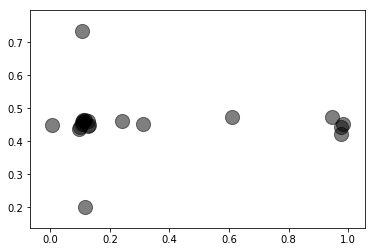

In [47]:
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

## 2) Spectral clustering
Spectral clustering is a family of methods to find K clusters using the eigenvectors
of a matrix. Typically, this matrix is derived from a set of pairwise similarities Sij
between the points to be clustered. This task is called similarity based clustering,
graph clustering, or clustering of diadic data.
One remarkable advantage of spectral clustering is its ability to cluster “points”
which are not necessarily vectors, and to use for this a“similarity”, which is less restrictive
than a distance. A second advantage of spectral clustering is its flexibility; it can
find clusters of arbitrary shapes, under realistic separations.


In [53]:
from sklearn.cluster import SpectralClustering
SCmodel = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = SCmodel.fit_predict(X)


C:\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:234: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.

